<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Two-qubit Quantum Random Access Coding (QRAC)*_ 

For more information about how to use the IBM Q experience (QX), consult the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).
***
### Contributors
Rudy Raymond, Takashi Imamichi

## Introduction

Thanks to the superposition of quantum states, by QRAC a single qubit can be used to encode up to 3 bits $x_1x_2x_3$ of information so that any one bit $x_i$ can be recovered with probability at least $0.78$. What happens if we have more qubits? As more qubits are available, we can go beyond a simple combination of QRAC of individual qubit by leveraging the entanglement. With two qubits, we can clearly use $(3,1)$-QRAC on each qubit and obtain a $(6,2)$-QRAC. Can we encode more bits? The answer is yes. Notice that two classical bits can be used to encode only up to 3 bits of information in the random access coding. 

We will show a $(7,2)$-QRAC following Example 4 in the paper [here](http://iopscience.iop.org/article/10.1088/1367-2630/8/8/129/meta). The success probability is $0.54$, which is slightly better than random guessing. The $(7,2)$-QRAC in the example uses [*quantum mixed states*](https://en.wikipedia.org/wiki/Quantum_state#Mixed_states) to mix two $(3,1)$-QRACs, for encoding the first six bits $x_1x_2x_3x_4x_5x_6$, with the encoding of of the seventh bit $x_7$. Namely, the mixed state contains, with probability $\alpha \equiv \frac{6}{7+\sqrt{3}}$, two $(3,1)$-QRACs encoding the first six bits, and the encoding of $x_7$ that entangles the first qubit and the second qubit (if $x_7 = 0$, the two qubits become $|00\rangle + |11\rangle$, or $|01\rangle+|10\rangle$ otherwise) with probability $1 - \alpha$.

The *quantum mixed states* used in the $(7,2)$-QRAC can be created by the sender using a series of unitary operations on three qubits by using the first qubit to control the mixing probability. The sender then send the last two qubits (the second and third ones) that are used by the receiver to decode his choice of bit. 

The procedure is as follows. First, the sender prepares three qubits $|000\rangle$ and transforms them to obtain

\begin{eqnarray}
|000\rangle &\xrightarrow{U(1.187, 0, 0)}& \sqrt{\alpha} |000\rangle + \sqrt{1 - \alpha} |100\rangle,
\end{eqnarray}

where $U(1.187,0,0)$ is the single-qubit rotation gate applied to the first qubit. Notice that $\cos(1.187/2) \approx \sqrt\alpha$.

Next, the sender uses her first qubit to control the value of the second and third qubits. When, the first qubit is $0$, the sender encodes the $x_1x_2x_3$ into the second qubit, and the $x_4x_5x_6$ into the third qubit. This means, she performs the following transformation (note that $V$ is conditioned on $x_1x_2x_3x_4x_5x_6$), 

\begin{eqnarray}
|000\rangle &\xrightarrow{V}& |0\rangle |\phi\left(x_1x_2x_3\right)\rangle |\phi\left(x_4x_5x_6\right)\rangle,
\end{eqnarray}

where $|\phi\left(xyz\right)\rangle$ is the $(3,1)$-QRAC of $xyz$. Otherwise, when the second qubit is $1$, the sender encodes the $x_7$ by using the Bell states. Namely, by entangling the second and the third qubit so that when $x_7 = 0$ the second and third qubits are the same, and when $x_7 = 1$ they are different, as follows. 

\begin{eqnarray}
|100\rangle & \xrightarrow{\mbox{if}~x_7 = 0} & |1\rangle\left( \frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}} |11\rangle\right) \equiv |1\rangle|\xi(0)\rangle \\
|100\rangle & \xrightarrow{\mbox{if}~x_7 = 1} & |1\rangle\left(\frac{1}{\sqrt{2}}|01\rangle + \frac{1}{\sqrt{2}} |10\rangle\right) \equiv |1\rangle|\xi(1)\rangle 
\end{eqnarray}

The second and third qubits are then sent to the receiver, who performs measurement to obtain his desired bit. Notice that because the receiver does not have the first qubit, the state of his two qubits is the mixed state as below

$$
\rho\left(x_1x_2\ldots x_7\right) = \alpha |\phi\left(x_1x_2x_3\right)\rangle\langle\phi\left(x_1x_2x_3\right)| \otimes |\phi\left(x_4x_5x_6\right)\rangle\langle\phi\left(x_4x_5x_6\right)|   + (1-\alpha) |\xi\left(x_7\right)\rangle\langle\xi\left(x_7\right)| 
$$

Now, the receiver can recover any one bit of $x_1x_2\ldots x_7$ as follows. If he wants to obtain any one bit of $x_1x_2x_3$, he measures his first qubit using the measurements of $(3,1)$-QRAC. Similarly, if he wants to obtain any one bit of $x_4x_5x_6$, he measures his second qubit using the measurements of $(3,1)$-QRAC. Finally, if he wants to obtain the seventh bit $x_7$, he measures both qubits and concludes that $x_7 = 0$ if the outcome of the measurement is the same (they are both $0$ or $1$), or $x_7 = 1$ otherwise.

Now, we show how to perform the experiment on the above $(7,2)$-QRAC using the IBM Q Experience. We first prepare the environment.

In [1]:
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")

# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# useful math functions
from math import pi, cos, acos, sqrt

sys.path.append("../../")
# importing the QISKit
from qiskit import QuantumProgram
import Qconfig

# import basic plot tools
from qiskit.basicplotter import plot_histogram

We prepare the controlled-Hadamard and controlled-u3 gates that are required in the encoding as below.

In [2]:
def ch(qProg, a, b):
    """ Controlled-Hadamard gate """
    qProg.h(b)
    qProg.sdg(b)
    qProg.cx(a, b)
    qProg.h(b)
    qProg.t(b)
    qProg.cx(a, b)
    qProg.t(b)
    qProg.h(b)
    qProg.s(b)
    qProg.x(b)
    qProg.s(a)
    return qProg

def cu3(qProg, theta, phi, lambd, c, t):
    """ Controlled-u3 gate """
    qProg.u1((lambd-phi)/2, t)
    qProg.cx(c, t)
    qProg.u3(-theta/2, 0, -(phi+lambd)/2, t)
    qProg.cx(c, t)
    qProg.u3(theta/2, phi, 0, t)
    return qProg

## Encoding 7 bits into 2 qubits with $(7,2)$-QRAC

The sender prepares the state to be sent by working on 3 qubits and uses the first one to control the mixture. She needs controlled unitary gates of $(3,1)$-QRAC encoding for her first 6 bits. When the first qubit is zero, she encodes $x_1x_2x_3$ into the second qubit, and $x_4x_5x_6$ into the third qubit. This can be realized with NOT on the first qubit followed by controlled $(3,1)$-QRAC gates with the first qubit as control and the second and third qubits as targets.

To encode $x_7$, when $x_7 = 0$ the sender applies a controlled Hadamard on the second qubit (with the first qubit as control), and apply Toffoli gate on the third qubit using the first and second qubits as controls. When $x_7 = 1$, the sender flips the second and third qubits before applying the same operations as when $x_7 = 0$. 

The decoding operations are the same as those of $(3,1)$-QRAC, and for encoding $x_7$, the receiver just measure the value of the second and third qubit on the computational basis.  

Below is the quantum circuits for encoding `"0101010"` and decoding any one bit with $(7,2)$-QRAC.  

In [3]:
#CHANGE THIS 7BIT 0-1 STRING TO PERFORM EXPERIMENT ON ENCODING 0000000, ..., 1111111
x1234567 = "0101010"

if len(x1234567) != 7 or not("1" in x1234567 or "0" in x1234567):
    raise Exception("x1234567 is a 7-bit 0-1 pattern. Please set it to the correct pattern")
    
#compute the value of rotation angle theta of (3,1)-QRAC 
theta = acos(sqrt(0.5 + sqrt(3.0)/6.0))

#to record the u3 parameters for encoding 000, 010, 100, 110, 001, 011, 101, 111
rotationParams = {"000":(2*theta, pi/4, -pi/4), "010":(2*theta, 3*pi/4, -3*pi/4), 
                  "100":(pi-2*theta, pi/4, -pi/4), "110":(pi-2*theta, 3*pi/4, -3*pi/4), 
                  "001":(2*theta, -pi/4, pi/4), "011":(2*theta, -3*pi/4, 3*pi/4), 
                  "101":(pi-2*theta, -pi/4, pi/4), "111":(pi-2*theta, -3*pi/4, 3*pi/4)}

Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url

# Creating registers
# qubits for encoding 7 bits of information with qr[0] kept by the sender
qr = Q_program.create_quantum_registers("qr", 3)
# bits for recording the measurement of the qubits qr[1] and qr[2]
cr = Q_program.create_classical_registers("cr", 2)

encodingName = "Encode"+x1234567
encodingCircuit = Q_program.create_circuit(encodingName, ["qr"], ["cr"])

#Prepare superposition of mixing QRACs of x1...x6 and x7
encodingCircuit.u3(1.187, 0, 0, qr[0])

#Encoding the seventh bit
seventhBit = x1234567[6]
if seventhBit == "1":  #copy qr[0] into qr[1] and qr[2]
    encodingCircuit.cx(qr[0], qr[1])
    encodingCircuit.cx(qr[0], qr[2])
    
#perform controlled-Hadamard qr[0], qr[1], and toffoli qr[0], qr[1] , qr[2]
encodingCircuit = ch(encodingCircuit, qr[0], qr[1])
encodingCircuit.ccx(qr[0], qr[1], qr[2])
#End of encoding the seventh bit

#encode x1...x6 with two (3,1)-QRACS. To do that, we must flip q[0] so that the controlled encoding is executed
encodingCircuit.x(qr[0])

#Encoding the first 3 bits 000, ..., 111 into the second qubit, i.e., (3,1)-QRAC on the second qubit
firstThreeBits = x1234567[0:3]
#encodingCircuit.cu3(*rotationParams[firstThreeBits], qr[0], qr[1])
encodingCircuit = cu3(encodingCircuit, *rotationParams[firstThreeBits], qr[0], qr[1])

#Encoding the second 3 bits 000, ..., 111 into the third qubit, i.e., (3,1)-QRAC on the third qubit
secondThreeBits = x1234567[3:6]
#encodingCircuit.cu3(*rotationParams[secondTreeBits], qr[0], qr[2])
encodingCircuit = cu3(encodingCircuit, *rotationParams[secondThreeBits], qr[0], qr[2])

#end of encoding
encodingCircuit.barrier()

# dictionary for decoding circuits
decodingCircuits = {}
# Quantum circuits for decoding the 1st to 6th bits
for i, pos in enumerate(["First", "Second", "Third", "Fourth", "Fifth", "Sixth"]):
    circuitName = "Decode"+pos
    decodingCircuits[circuitName] = Q_program.create_circuit(circuitName, ["qr"], ["cr"])
    if i < 3: #measure 1st, 2nd, 3rd bit
        if pos == "Second": #if pos == "First" we can directly measure
            decodingCircuits[circuitName].h(qr[1])
        elif pos == "Third":
            decodingCircuits[circuitName].u3(pi/2, -pi/2, pi/2, qr[1])
        decodingCircuits[circuitName].measure(qr[1], cr[1])
    else: #measure 4th, 5th, 6th bit
        if pos == "Fifth": #if pos == "Fourth" we can directly measure
            decodingCircuits[circuitName].h(qr[2])
        elif pos == "Sixth":
            decodingCircuits[circuitName].u3(pi/2, -pi/2, pi/2, qr[2])
        decodingCircuits[circuitName].measure(qr[2], cr[1])

        #Quantum circuits for decoding the 7th bit
decodingCircuits["DecodeSeventh"] = Q_program.create_circuit("DecodeSeventh", ["qr"], ["cr"])
decodingCircuits["DecodeSeventh"].measure(qr[1], cr[0])
decodingCircuits["DecodeSeventh"].measure(qr[2], cr[1])

#combine encoding and decoding of (7,2)-QRACs to get a list of complete circuits
circuitNames = []
k1 = encodingName
for k2 in decodingCircuits.keys():
    circuitNames.append(k1+k2)
    Q_program.add_circuit(k1+k2, encodingCircuit+decodingCircuits[k2])

print("List of circuit names:", circuitNames) #list of circuit names
#Q_program.get_qasms(circuitNames) #list qasms codes

>> quantum_registers created: qr 3
>> classical_registers created: cr 2
List of circuit names: ['Encode0101010DecodeFirst', 'Encode0101010DecodeSecond', 'Encode0101010DecodeThird', 'Encode0101010DecodeFourth', 'Encode0101010DecodeFifth', 'Encode0101010DecodeSixth', 'Encode0101010DecodeSeventh']


We can experiments with different encoding of seven bits by changing the value `x1234567="0101010"` at the code above. Below is the plot of experiment results of extracting the first to six bit, that results in observing the-$i$th bit with probability at least $0.54$ 

running on backend: simulator
Experimental Result of  Encode0101010DecodeFirst


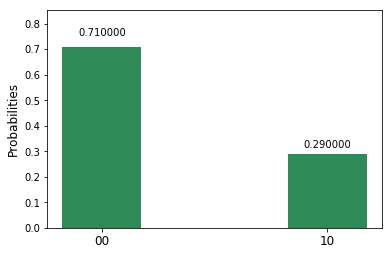

Experimental Result of  Encode0101010DecodeSecond


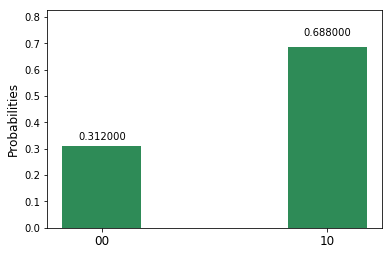

Experimental Result of  Encode0101010DecodeThird


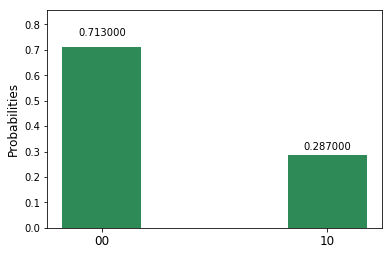

Experimental Result of  Encode0101010DecodeFourth


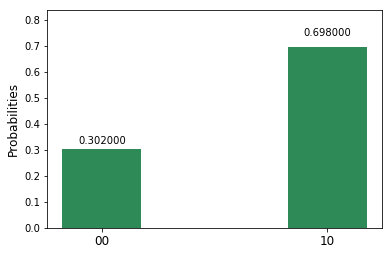

Experimental Result of  Encode0101010DecodeFifth


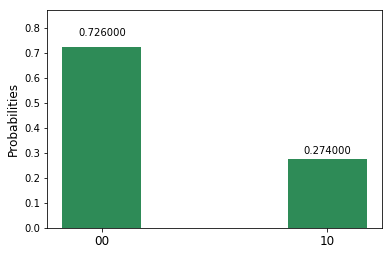

Experimental Result of  Encode0101010DecodeSixth


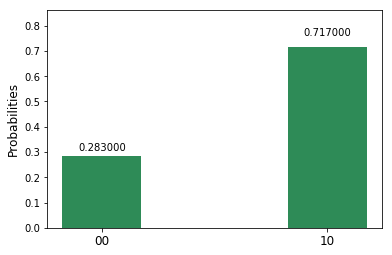

In [4]:
device = "simulator"
shots = 1000
Q_program.execute(circuitNames, device, shots, max_credits=3, wait=10, timeout=240)
for k in ["DecodeFirst", "DecodeSecond", "DecodeThird", "DecodeFourth", "DecodeFifth", "DecodeSixth"]:
    print("Experimental Result of ", encodingName+k)
    plot_histogram(Q_program.get_counts(encodingName+k))

The seventh bit is obtained by looking at the content of classical registers. If they are the same, i.e., both are `1` or `0`, then we conclude that it is `0`, or otherwise `1`. For the encoding of `0101010`, the seventh bit is `0`, so the total probability of observing `00` and `11` must exceed that of observing `01` and `10`. 

Experimental result of  Encode0101010DecodeSeventh


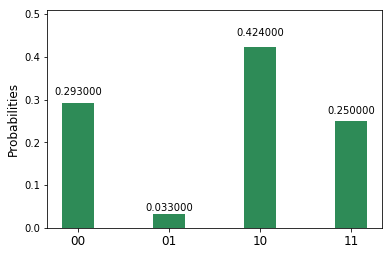

In [5]:
print("Experimental result of ", encodingName+"DecodeSeventh")
plot_histogram(Q_program.get_counts(encodingName+"DecodeSeventh"))

We can experiment with other seven-bit encoding by changing the value `x1234567` of the code above, and see that in any case we can decode the correct bit with probability strictly better than random guessing. 

## About Quantum Random Access Coding
The success probability $(7,2)$-QRAC shown above is not high due to the use of mixed states. There exists a better code using pure states as shown [here](https://arxiv.org/abs/1607.02667), where the success probability becomes $0.68$. [The paper](https://arxiv.org/abs/1607.02667) also shows the construction of $(n,2)$-QRACs with pure states for $n=7,\ldots,12$. It is still open if there is a coding scheme with only pure states for $n=13, 14, 15$. Notice that $(n, m)$-QRACs exist for $ n \le 2^{2m}-1$ that can be realized with mixed states as shown [here](http://link.springer.com/chapter/10.1007/978-3-540-73420-8_12).